## Prerequisites

In [3]:
from core import *

## Global variables

In [17]:
device

'cpu'

In [18]:
train_data_percent = 0.75

In [19]:
random_seed = 42


## Weight&Biases Enabling

In [21]:
# Log in to your W&B account
# 2f66fbbb33d3c09822c4891449faf2c870190b8d
import wandb
WANDB_API_KEY = '2f66fbbb33d3c09822c4891449faf2c870190b8d'
wandb.login()

True

## Создание графа корреляций между монетами


In [28]:


def generate_features(mmf_data_raw,price_grid_raw,preserve_cols=['DVOL']):
    dset = (mmf_data_raw.BEST_ASK/2 + mmf_data_raw.BEST_BID/2).to_frame('MID_PRICE') 

    dset['TG_Y'] =  (mmf_data_raw['VWAP'].shift(-2) - mmf_data_raw['VWAP'].shift(-1)) / mmf_data_raw['VWAP'].shift(-1)
    
    dset['R1_X'] =  (dset['MID_PRICE'] - dset['MID_PRICE'].shift(1)) * 100
    dset['R2_X'] =  (dset['MID_PRICE'] - dset['MID_PRICE'].shift(2) ) * 100

    dset['R1V_X'] =  (mmf_data_raw['VWAP'] - mmf_data_raw['VWAP'].shift(1)) * 100
    dset['R2V_X'] =  (mmf_data_raw['VWAP'] - mmf_data_raw['VWAP'].shift(2) ) * 100
    
    dset['RVW_ema_X'] =  mmf_data_raw['VWAP'] - mmf_data_raw['VWAP'].ewm(halflife=8).mean()
    dset['RVW_ema2_X'] =  mmf_data_raw['VWAP'].ewm(halflife=8).mean() - mmf_data_raw['VWAP'].ewm(halflife=16).mean() 
    # как работает цена относительно ее скользящего среднее
    # насколько одно скользяшее среднее опережает другое скользящее среднее (?)
    # гармонический анализ
    dset['RVW_ema3_X'] =  mmf_data_raw['VWAP'].ewm(halflife=16).mean() - mmf_data_raw['VWAP'].ewm(halflife=32).mean()
    dset['RVW_ema4_X'] =  mmf_data_raw['VWAP'].ewm(halflife=32).mean() - mmf_data_raw['VWAP'].ewm(halflife=64).mean()
    
    for col in preserve_cols:
        dset[f"{col}_X"] = mmf_data_raw[col]
    
    dset['DVOL_EMA3_X'] = dset['DVOL_X'].ewm(halflife=3).mean()
    dset['DVOL_EMA10_X'] = dset['DVOL_X'].ewm(halflife=10).mean()

    # price grid - какие объемы стоят от Мид прайса до 
    # суммируем объем на всех уровнях, находящащаяся на выбранных ровнях
    # мид прайс - разница между (бест бид и бест оффер) / 2 

    dset['BTC_BID_VOL'] = price_grid_raw[['PRICE_GRID_0.991026', 'PRICE_GRID_0.993590', 'PRICE_GRID_0.996154', 'PRICE_GRID_0.998718']].sum(axis=1).abs()
    dset['BTC_ASK_VOL'] = price_grid_raw[['PRICE_GRID_1.001282','PRICE_GRID_1.003846', 'PRICE_GRID_1.006410', 'PRICE_GRID_1.008974']].sum(axis=1).abs()
    dset['OIR_X'] = (dset['BTC_BID_VOL'] - dset['BTC_ASK_VOL']) / (dset['BTC_BID_VOL'] + dset['BTC_ASK_VOL'])
    
    X, y = dset.filter(like='_X'), dset.filter(like='_Y')
    return X,y


---

In [5]:
tickers = get_tickers()
print(tickers)

['Z.ADA' 'Z.BNB' 'Z.BTC' 'Z.DOGE' 'Z.DOT' 'Z.ETC' 'Z.ETH' 'Z.FIL' 'Z.LINK'
 'Z.LTC' 'Z.MATIC' 'Z.THETA' 'Z.UNI' 'Z.XRP']


In [30]:
# selected_tickers=['Z.ADA', 'Z.BTC', 'Z.ETH', 'Z.MATIC']
selected_tickers = tickers

In [31]:
returns_all_tickers = pd.DataFrame(columns=selected_tickers)
aggregated_data_raw_all_tickers = []
X_mmf_all_tickers = []
y_regr_all_tickers = []

for ticker in selected_tickers:
    print(ticker)
    agg_mmf_data_raw,agg_price_grid_raw = get_market_data(ticker)
    
    adf_test_p_value = agg_mmf_data_raw.aggregate(get_adf_p_value,axis=0)
    # preserve_cols = adf_test_p_value.loc[lambda x: x<1e-4].index
    # TODO : high - non stationary 
    # важно:  изменения цены, а не цена!
    # HIGH - LOW = волатильность bara
    # 
    preserve_cols = ['BEST_BID_VOL', 'BEST_ASK_VOL', 'VOLUME', 'DVOL', 'HIGH', 'ENTROPY',
       'COUNT', 'COUNT_BUY', 'COUNT_SELL', 'MO_COUNT', 'MO_COUNT_BUY',
       'MO_COUNT_SELL', 'MO_AVG', 'MO_AVG_BUY', 'MO_AVG_SELL',
       'BREAK_BEST_DOWN', 'BREAK_BEST_UP', 'ASK_VOLUME', 'BID_VOLUME', 'HOUR',
       'MINUTE', 'BAR_DURATION']

    X_mmf,y_regr = generate_features(agg_mmf_data_raw,agg_price_grid_raw,preserve_cols=preserve_cols)
    y_regr = y_regr * 100
    nna_indices = X_mmf.notnull().min(axis=1) & agg_price_grid_raw.notnull().min(axis=1) & y_regr.notnull().min(axis=1)
    agg_mmf_data_raw,agg_price_grid_raw,X_mmf,y_regr = agg_mmf_data_raw[nna_indices],agg_price_grid_raw[nna_indices],X_mmf[nna_indices],y_regr[nna_indices]

    returns_all_tickers[ticker] = (agg_mmf_data_raw['LAST'] - agg_mmf_data_raw['LAST'].shift(1)) / agg_mmf_data_raw['LAST'].shift(1)
    aggregated_data_raw_all_tickers.append(agg_mmf_data_raw)
    X_mmf_all_tickers.append(X_mmf)
    y_regr_all_tickers.append(y_regr)
    

Z.ADA


KeyboardInterrupt: 

Убедиться гидростичность единичный корень центрированность
- одинаковое std 
- гетероскидестичность
- поделить на скользящую волатильность (std) (например: число изменилось на 2%)
- единичный корень (пример: цена), первый диференс стационарный 
- HIGH использовать с LOW
- 

In [ ]:
X_mmf_all_tickers[0]

,R1_X,R2_X,R1V_X,R2V_X,RVW_ema_X,RVW_ema2_X,RVW_ema3_X,RVW_ema4_X,BEST_BID_VOL_X,BEST_ASK_VOL_X,...,BREAK_BEST_DOWN_X,BREAK_BEST_UP_X,ASK_VOLUME_X,BID_VOLUME_X,HOUR_X,MINUTE_X,BAR_DURATION_X,DVOL_EMA3_X,DVOL_EMA10_X,OIR_X
bar_time,,,,,,,,,,,,,,,,,,,,,
2021-01-01 00:08:29.527000064,-0.090,-0.190,-0.102858,-0.167215,-0.000852,-0.000024,-0.000012,-0.000006,792.0,14802.0,...,270.0,285.0,4253777.0,5635705.0,0.0,8.0,2.034610e+11,-860660.029372,-778579.253819,-0.055697
2021-01-01 00:10:31.216999936,-0.015,-0.105,-0.028504,-0.131362,-0.000815,-0.000037,-0.000019,-0.000009,43448.0,21581.0,...,210.0,184.0,5756618.0,6235651.0,0.0,10.0,1.216900e+11,-579236.493935,-573728.629007,-0.400927
2021-01-01 00:12:11.052999936,-0.030,-0.045,-0.040127,-0.068631,-0.000929,-0.000051,-0.000026,-0.000013,1717.0,55750.0,...,127.0,133.0,4105592.0,6335000.0,0.0,12.0,9.983600e+10,-515810.872389,-526835.175095,-0.254889
2021-01-01 00:13:57.256000000,-0.050,-0.080,-0.014477,-0.054604,-0.000854,-0.000063,-0.000032,-0.000016,1613.0,3157.0,...,192.0,216.0,4294203.0,5703267.0,0.0,13.0,1.062030e+11,-331443.543156,-392744.079420,-0.062382
2021-01-01 00:14:38.403000064,-0.010,-0.060,-0.048989,-0.063466,-0.001099,-0.000080,-0.000041,-0.000021,3341.0,549.0,...,102.0,107.0,3846861.0,4947315.0,0.0,14.0,4.114700e+10,-245884.087777,-324154.704105,0.038236
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-31 23:31:11.516000000,0.060,-0.060,-0.094071,-0.010759,-0.000761,0.001103,0.004204,0.005895,6591.0,2348.0,...,60.0,56.0,13017074.0,21393057.0,23.0,31.0,1.970200e+11,18801.262380,-13429.249491,-0.120660
2021-10-31 23:33:05.256000000,-0.340,-0.280,-0.106931,-0.201002,-0.001679,0.000982,0.004099,0.005868,1966.0,8084.0,...,58.0,33.0,13017375.0,21454142.0,23.0,33.0,1.137400e+11,4412.232537,-15941.701007,-0.053074
2021-10-31 23:37:08.680000000,0.240,-0.100,0.063130,-0.043801,-0.000961,0.000898,0.004010,0.005848,1203.0,25754.0,...,81.0,121.0,13125560.0,21440105.0,23.0,37.0,2.434240e+11,-6886.012429,-18246.189725,-0.118656


In [ ]:
with open(os.path.join(save_path,'returns_all_tickers.pickle'), 'wb') as output:
  pickle.dump(returns_all_tickers, output)

with open(os.path.join(save_path,'aggregated_data_raw_all_tickers.pickle'), 'wb') as output:
  pickle.dump(aggregated_data_raw_all_tickers, output)

with open(os.path.join(save_path,'X_mmf_all_tickers.pickle'), 'wb') as output:
  pickle.dump(X_mmf_all_tickers, output)

with open(os.path.join(save_path, 'y_regr_all_tickers.pickle'), 'wb') as output:
  pickle.dump(y_regr_all_tickers, output)

In [ ]:
with open(os.path.join(save_path,'returns_all_tickers.pickle'), 'rb') as input:
  returns_all_tickers = pickle.load(input)

with open(os.path.join(save_path,'aggregated_data_raw_all_tickers.pickle'), 'rb') as input:
  aggregated_data_raw_all_tickers = pickle.load(input)

with open(os.path.join(save_path,'X_mmf_all_tickers.pickle'), 'rb') as input:
  X_mmf_all_tickers = pickle.load(input)

with open(os.path.join(save_path,'y_regr_all_tickers.pickle'), 'rb') as input:
  y_regr_all_tickers = pickle.load(input)

DF : всё коррелировано с рынком. Убрать рынок!
1 компонентна PCA.

crypto[i] - PCA[0]





<AxesSubplot:>

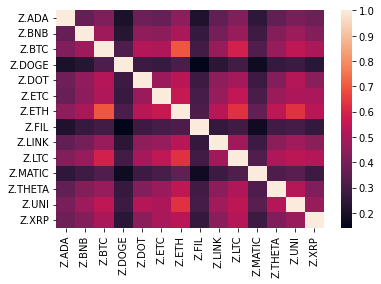

In [ ]:
sns.heatmap(returns_all_tickers.corr())

In [ ]:
links=returns_all_tickers.corr().stack().reset_index()
links.columns = ['var1', 'var2', 'value']
correlation_threshold = 0.5

In [ ]:
links_filtered=links.loc[ (links['value'] > correlation_threshold) & (links['var1'] != links['var2']) ]

In [ ]:
# links_filtered=links.loc[ (links['value'] > correlation_threshold)]

In [ ]:
num_of_links = links_filtered.shape[0] // 2
num_of_links

21

пирсоновская кореляция спирмановская 

directed graph (!) 
влияние ETH на UNI

тест грейнджера между двумя активами, выбираю порог, при котором статистика больше чем порог (колво связей оставшихся) 

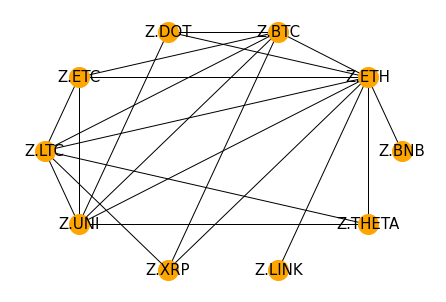

In [ ]:
G=nx.from_pandas_edgelist(links_filtered, 'var1', 'var2')
 
# Plot the network:
pos = nx.circular_layout(G)
nx.draw(G, with_labels=True, pos=pos, node_color='orange', node_size=400, edge_color='black', linewidths=1, font_size=15)

## Create dataset

In [ ]:
class MyOwnDataset(InMemoryDataset):
    def __init__(self, root, X_multi_idx_df_to_dataset, y_multi_idx_df_to_dataset, selected_tickers, transform=None, pre_transform=None, pre_filter=None):
        self.X = X_multi_idx_df_to_dataset
        self.Y = y_multi_idx_df_to_dataset
        super().__init__(root, transform, pre_transform, pre_filter)
        self.data, self.slices = torch.load(self.processed_paths[0])


    @property
    def processed_file_names(self):
        return ['data.pt']

    def process(self):
        # n_timestamps = self.X.index.levels[1].shape[0] # 7296 vs 7007 (real)
        n_timestamps = self.X.loc[selected_tickers[0]].index.shape[0]

        data_list = []

        time_stamps = self.X.index.levels[1]

        for idx_ts in tqdm(range(n_timestamps)):

            multi_index_table_all_tickers_for_one_day = pd.concat([self.X.loc[ticker].iloc[idx_ts] for ticker in selected_tickers], keys = selected_tickers).unstack(level=1)
            y_regr_all_tickers_for_one_day = pd.concat([self.Y.loc[ticker].iloc[idx_ts] for ticker in selected_tickers], keys = selected_tickers).unstack(level=1)#.reshape(-1, 1)

            x = multi_index_table_all_tickers_for_one_day
            y = y_regr_all_tickers_for_one_day

            x = torch.tensor(x.to_numpy(), dtype=torch.float).to(device)
            y = torch.tensor(y.to_numpy(), dtype=torch.float).to(device)
            graph = Data(x=x, edge_index=edge_index,  y=y)
            data_list.append(graph)    

        if self.pre_filter is not None:
            data_list = [data for data in data_list if self.pre_filter(data)]

        if self.pre_transform is not None:
            data_list = [self.pre_transform(data) for data in data_list]

        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])

In [ ]:
def convert_list_of_dfs_to_one_multi_index_df(list_of_df, selected_tickers, resample = None):
  df = pd.concat(list_of_df, keys = selected_tickers)
  df.index.names = ['ticker','bar_time'] 
  df.index = df.index.set_levels(pd.to_datetime(df.index.levels[1]), level=1)

  
  if resample is not None:
    df=df.groupby([pd.Grouper(level='ticker'), 
              pd.Grouper(level='bar_time', freq=resample)]
            ).first()
  return df

TODO : сделать 5 минутные интервалы 

объемы - суммировать

цены - разница между хай и лоу

энтропия цен

**пока оставить как есть**

2 минуты = долго работает легко предсказывает

15 минут = наоборот

In [ ]:
resample = 'H'

In [ ]:
X_multi_idx_df_to_dataset = convert_list_of_dfs_to_one_multi_index_df(X_mmf_all_tickers, selected_tickers, resample=resample)
y_multi_idx_df_to_dataset = convert_list_of_dfs_to_one_multi_index_df(y_regr_all_tickers, selected_tickers, resample=resample)

In [ ]:
X_multi_idx_df_to_dataset

R1_X   R2_X     R1V_X     R2V_X  RVW_ema_X  \
ticker bar_time                                                           
Z.ADA  2021-01-01 00:00:00 -0.090 -0.190 -0.102858 -0.167215  -0.000852   
       2021-01-01 01:00:00 -0.020 -0.040 -0.032757 -0.010390   0.000553   
       2021-01-01 02:00:00  0.015  0.020  0.015043  0.001053   0.001053   
       2021-01-01 03:00:00 -0.035 -0.035 -0.023459 -0.042152   0.000115   
       2021-01-01 04:00:00  0.020  0.010  0.004410 -0.005368  -0.000536   
...                           ...    ...       ...       ...        ...   
Z.XRP  2021-10-31 19:00:00  0.050 -0.070 -0.103106 -0.112462   0.001060   
       2021-10-31 20:00:00  0.010  0.070  0.053754 -0.136078  -0.000908   
       2021-10-31 21:00:00  0.050 -0.150 -0.013247 -0.177568   0.000886   
       2021-10-31 22:00:00  0.160 -0.020 -0.125861 -0.023279   0.006997   
       2021-10-31 23:00:00 -0.020  0.030  0.094474  0.102790  -0.001107   

                            RVW_ema2_X  RVW_ema3_X  RVW_ema4_X  \
ticker bar_time                                                  
Z.ADA  2021-01-01 00:00:00   -0.000024   -0.000012   -0.000006   
       2021-01-01 01:00:00    0.000081    0.000031    0.000012   
       2021-01-01 02:00:00    0.000696    0.000467    0.000250   
       2021-01-01 03:00:00    0.000583    0.000612    0.000393   
       2021-01-01 04:00:00    0.000269    0.000512    0.000402   
...                                ...         ...         ...   
Z.XRP  2021-10-31 19:00:00    0.000847    0.001856    0.000535   
       2021-10-31 20:00:00    0.002063    0.002819    0.001594   
       2021-10-31 21:00:00    0.001986    0.003126    0.002455   
       2021-10-31 22:00:00    0.005523    0.006515    0.005595   
       2021-10-31 23:00:00    0.001537    0.005043    0.006178   

                            BEST_BID_VOL_X  BEST_ASK_VOL_X  ...  \
ticker bar_time                                             ...   
Z.ADA  2021-01-01 00:00:00           792.0         14802.0  ...   
       2021-01-01 01:00:00          1300.0         36671.0  ...   
       2021-01-01 02:00:00          3384.0          6501.0  ...   
       2021-01-01 03:00:00           294.0          3052.0  ...   
       2021-01-01 04:00:00          1091.0         36086.0  ...   
...                                    ...             ...  ...   
Z.XRP  2021-10-31 19:00:00         19651.7          2369.5  ...   
       2021-10-31 20:00:00         17621.7          7742.9  ...   
       2021-10-31 21:00:00          4971.4         21736.6  ...   
       2021-10-31 22:00:00         16527.7         11626.2  ...   
       2021-10-31 23:00:00          3433.1         31891.6  ...   

                            BREAK_BEST_DOWN_X  BREAK_BEST_UP_X  ASK_VOLUME_X  \
ticker bar_time                                                                
Z.ADA  2021-01-01 00:00:00              270.0            285.0     4253777.0   
       2021-01-01 01:00:00              263.0            228.0     4773483.0   
       2021-01-01 02:00:00              209.0            187.0    11025749.0   
       2021-01-01 03:00:00              335.0            251.0     8949691.0   
       2021-01-01 04:00:00              327.0            311.0    11350217.0   
...                                       ...              ...           ...   
Z.XRP  2021-10-31 19:00:00              117.0            104.0    25444687.9   
       2021-10-31 20:00:00               77.0             86.0    25276127.3   
       2021-10-31 21:00:00               44.0             41.0    25744708.0   
       2021-10-31 22:00:00               21.0             31.0    25503685.6   
       2021-10-31 23:00:00               55.0             53.0    26118069.6   

                            BID_VOLUME_X  HOUR_X  MINUTE_X  BAR_DURATION_X  \
ticker bar_time                                                              
Z.ADA  2021-01-01 00:00:00     5635705.0     0.0       8.0    2.034610e+11   
       2021-01-01 01:00:00    15705274.0     1.

Note : Data Transformation comes AFTER resampling

In [ ]:
train_index = int(X_multi_idx_df_to_dataset.loc[selected_tickers[0]].shape[0] * train_data_percent) 
last_day_of_train_dataset = X_multi_idx_df_to_dataset.loc[selected_tickers[0]].index[train_index]
last_day_of_train_dataset

Timestamp('2021-08-17 00:00:00')

In [ ]:
transformer = None

ТРАНСФОРМИРОВАТЬ данные после ресэмпл!

In [ ]:
from sklearn.preprocessing import QuantileTransformer
transformer = 'QuantileTransformer'

qt = QuantileTransformer(output_distribution='normal')

idx = pd.IndexSlice
train_X_features = X_multi_idx_df_to_dataset.loc[idx[:, : last_day_of_train_dataset], :]
qt.fit(train_X_features)
pd.DataFrame(qt.transform(X_multi_idx_df_to_dataset), columns=X_multi_idx_df_to_dataset.columns, index=X_multi_idx_df_to_dataset.index)


R1_X      R2_X     R1V_X     R2V_X  RVW_ema_X  \
ticker bar_time                                                                 
Z.ADA  2021-01-01 00:00:00 -0.283197 -0.309743 -0.309491 -0.330930  -0.227339   
       2021-01-01 01:00:00 -0.177827 -0.160010 -0.192843 -0.111248   0.050023   
       2021-01-01 02:00:00  0.003764  0.047682  0.062377 -0.040939   0.116074   
       2021-01-01 03:00:00 -0.205941 -0.149853 -0.168047 -0.195909  -0.031683   
       2021-01-01 04:00:00  0.020074  0.011291  0.007638 -0.088113  -0.186979   
...                              ...       ...       ...       ...        ...   
Z.XRP  2021-10-31 19:00:00  0.074087 -0.205941 -0.309784 -0.289290   0.116633   
       2021-10-31 20:00:00 -0.008782  0.132113  0.162968 -0.308954  -0.232398   
       2021-10-31 21:00:00  0.084155 -0.287442 -0.128310 -0.341442   0.098875   
       2021-10-31 22:00:00  0.211070 -0.118204 -0.330608 -0.152040   0.341803   
       2021-10-31 23:00:00 -0.177827  0.066541  0.216182  0.169428  -0.250993   

                            RVW_ema2_X  RVW_ema3_X  RVW_ema4_X  \
ticker bar_time                                                  
Z.ADA  2021-01-01 00:00:00   -0.115766   -0.142910   -0.139145   
       2021-01-01 01:00:00   -0.042964   -0.116712   -0.131547   
       2021-01-01 02:00:00    0.091378   -0.013827   -0.063329   
       2021-01-01 03:00:00    0.073111    0.007527   -0.041291   
       2021-01-01 04:00:00    0.012326   -0.006657   -0.039867   
...                                ...         ...         ...   
Z.XRP  2021-10-31 19:00:00    0.108996    0.127772   -0.022306   
       2021-10-31 20:00:00    0.210403    0.183576    0.067979   
       2021-10-31 21:00:00    0.205176    0.198063    0.119674   
       2021-10-31 22:00:00    0.330288    0.284289    0.216223   
       2021-10-31 23:00:00    0.174518    0.256781    0.225170   

                            BEST_BID_VOL_X  BEST_ASK_VOL_X  ...  \
ticker bar_time                                             ...   
Z.ADA  2021-01-01 00:00:00        0.785419        1.490930  ...   
       2021-01-01 01:00:00        0.876726        1.844052  ...   
       2021-01-01 02:00:00        1.084701        1.225837  ...   
       2021-01-01 03:00:00        0.596734        1.036944  ...   
       2021-01-01 04:00:00        0.850611        1.837992  ...   
...                                    ...             ...  ...   
Z.XRP  2021-10-31 19:00:00        1.600331        0.975401  ...   
       2021-10-31 20:00:00        1.556158        1.273081  ...   
       2021-10-31 21:00:00        1.174791        1.617620  ...   
       2021-10-31 22:00:00        1.530963        1.407443  ...   
       2021-10-31 23:00:00        1.087718        1.789753  ...   

                            BREAK_BEST_DOWN_X  BREAK_BEST_UP_X  ASK_VOLUME_X  \
ticker bar_time                                                                
Z.ADA  2021-01-01 00:00:00           0.758004         0.764710      0.667266   
       2021-01-01 01:00:00           0.721714         0.519225      0.693360   
       2021-01-01 02:00:00           0.437620         0.278302      0.944364   
       2021-01-01 03:00:00           1.016672         0.628724      0.871365   
       2021-01-01 04:00:00           0.989697         0.855287      0.955009   
...                                       ...              ...           ...   
Z.XRP  2021-10-31 19:00:00          -0.223916        -0.361511      1.246775   
       2021-10-31 20:00:00          -0.667419        -0.570161      1.241813   
       2021-10-31 21:00:00          -1.212751        -1.278137      1.258231   
       2021-10-31 22:00:00          -1.851734        -1.509656      1.248872   
       2021-10-31 23:00:00          -0.995858        -1.040090      1.272835   

                            BID_VOLUME_X    HOUR_X  MINUTE_X  BAR_DURATION_X  \
ticker bar_time                                                                
Z.ADA  2021-01-01 00:00:00      0.530373 -5.19

In [ ]:
for ticker in tickers:
  print(ticker, X_multi_idx_df_to_dataset.loc[ticker].isnull().values.sum())

Z.ADA 0
Z.BNB 0
Z.BTC 0
Z.DOGE 0
Z.DOT 0
Z.ETC 0
Z.ETH 0
Z.FIL 0
Z.LINK 0
Z.LTC 0
Z.MATIC 0
Z.THETA 0
Z.UNI 0
Z.XRP 0


In [ ]:
with open(os.path.join(save_path,f'X_mmf_multi_idx_to_dataset_RESAMPLED_{resample}.pickle'), 'wb') as output:
  pickle.dump(X_multi_idx_df_to_dataset, output)

with open(os.path.join(save_path,f'y_regr_multi_idx_to_dataset_RESAMPLED_{resample}.pickle'), 'wb') as output:
  pickle.dump(y_multi_idx_df_to_dataset, output)

In [ ]:
df_corrs = torch.tensor((returns_all_tickers.corr() > correlation_threshold).astype(int).to_numpy())
edge_index = df_corrs.nonzero().t().contiguous().to(device)
edge_index

tensor([[ 0,  1,  1,  2,  2,  2,  2,  2,  2,  2,  3,  4,  4,  4,  4,  5,  5,  5,
          5,  5,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  7,  8,  8,  9,  9,  9,
          9,  9,  9,  9, 10, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 13, 13,
         13, 13],
        [ 0,  1,  6,  2,  4,  5,  6,  9, 12, 13,  3,  2,  4,  6, 12,  2,  5,  6,
          9, 12,  1,  2,  4,  5,  6,  8,  9, 11, 12, 13,  7,  6,  8,  2,  5,  6,
          9, 11, 12, 13, 10,  6,  9, 11, 12,  2,  4,  5,  6,  9, 11, 12,  2,  6,
          9, 13]])

In [ ]:
selected_tickers=selected_tickers

In [ ]:
dataset = MyOwnDataset(f'Datase00{resample}',  X_multi_idx_df_to_dataset, y_multi_idx_df_to_dataset, selected_tickers)

Processing...
100%|██████████| 7007/7007 [02:40<00:00, 43.76it/s]
Done!


In [ ]:
dataset.data

Data(x=[98098, 33], edge_index=[2, 392392], y=[98098, 1])

In [ ]:
# with open(os.path.join(save_path,f'Dataset_based_on_{resample}_intervals_X_mmf_y_regr.pickle'), 'wb') as output:
#   pickle.dump(dataset, output)

In [ ]:
# with open(os.path.join(save_path,f'Dataset_based_on_{resample}_intervals_X_mmf_y_regr.pickle'), 'rb') as input:
  # dataset = pickle.load(input)

In [ ]:
train_idx = int(len(dataset) * train_data_percent) 
train = dataset[:train_idx]
val = dataset[train_idx:]
train

MyOwnDataset(5255)

## Архитектура сети

In [ ]:
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, hid_size1, hid_size2):
        super().__init__()
        self.linear1 = nn.Linear(in_features=dataset.num_node_features, out_features=hid_size1)
        self.conv1 = GCNConv(in_channels=hid_size1, out_channels=hid_size2)
        self.linear2 = nn.Linear(in_features=hid_size2, out_features=1)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        
        x = self.linear1(x)
        x = torch.tanh(x)

        x = self.conv1(x, edge_index)
        
        x = self.linear2(x)

        # return torch.tanh(x)
        return x

In [ ]:
def calc_loss(data, zeros = False):
    s = 0
    for i in range(len(data)):
        if zeros:
            s += loss(torch.zeros(data[0].x.shape[0]).to(device), data[i].y).item()
        else:
            s += loss(model(data[i]), data[i].y).item()
    return s/len(data)

In [ ]:
loss(model(train[0]),train[0].y).item()

1.0149365663528442

In [ ]:
loss = nn.MSELoss(reduction = 'mean')

train_benchmark = calc_loss(train, True)
test_benchmark = calc_loss(val, True)

train_benchmark, test_benchmark # mse of zero prediction

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([14, 1])) that is different to the input size (torch.Size([14])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


(0.07556620922923658, 0.03242407103855063)

In [ ]:
params = {
    'hid_size1' : 64,
    'hid_size2' : 32,
    
    'batch_size': 64,
    'learning_rate': 1e-02,
    'epochs': 10,

    'architecture': 'gcn',
    'data transform': transformer,
    'target': 'simple', 
    'random_seed' : random_seed,
    'correlation threshold' : correlation_threshold, 
    'num_of_links' : num_of_links # without loops
}

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = GAT(params['hid_size1'], params['hid_size2'], params['hid_size3'], params['dropout']).to(device)
# model = GAT(params['hid_size1'], params['dropout']).to(device)
model = GCN(params['hid_size1'], params['hid_size2']).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=params['learning_rate'])

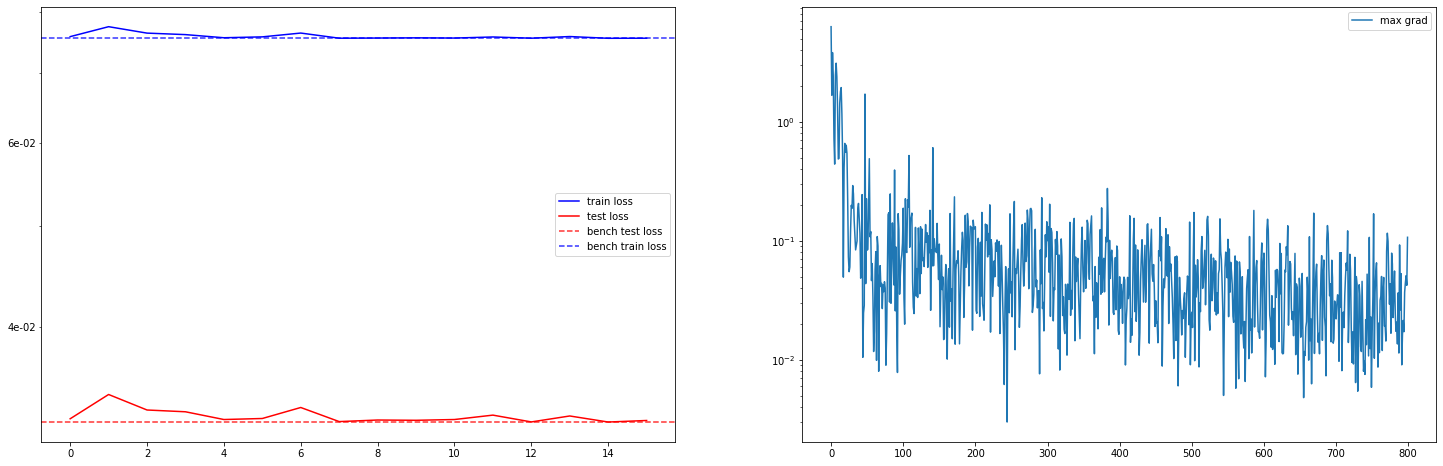

100%|██████████| 83/83 [00:15<00:00,  5.30it/s]


In [ ]:
train_loss_history = []
grad_history = []
train_history = []
test_history = []
    
wandb.init(
    project="GNN-for-crypto-stock-prediction",
    config=params,
    )
    
wandb.watch(model, log_freq=10)

for epoch in range(params['epochs']): 
    loader = DataLoader(train,batch_size=params['batch_size'],shuffle=False)
    
    with tqdm(loader) as progressbar:
        for episode in progressbar:
            episode = episode.to(device)
            pred = model(episode)
            train_loss = loss(pred, episode.y)
            train_loss_history.append(train_loss.item())
            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()
            
            grad_history.append( np.max([torch.max(p.grad).item() for p in model.parameters() if p.grad is not None]) )

            if len(train_loss_history) % 50 == 0:
                model.train(False) # disable learning mode

                train_loss = calc_loss(train)
                test_loss = calc_loss(val)

                train_history.append(train_loss) # losses calculcated on the whole history /
                test_history.append(test_loss)    # unlike row #8 where the current episode only

                model.train(True) # enable learning 

                make_plots(train_history, test_history, grad_history, train_benchmark, test_benchmark)


train_loss = calc_loss(train)
test_loss = calc_loss(val)

wandb.log({"train_loss": train_loss, 'test_loss': test_loss})
wandb.finish()

## Visualization tools

In [ ]:
def make_plots(train_history, test_history, grad_history, train_bench = None, test_bench = None):
    clear_output(True)

    fgs,axs = plt.subplots(1,2, figsize=[25,8])

    axs[1].plot(grad_history, label='max grad')
    axs[1].legend(loc='best')

    axs[0].plot(train_history, label='train loss', color='blue')
    axs[0].plot(test_history, label='test loss', color='red')
    axs[0].set_yscale('log')
    axs[1].set_yscale('log')
    axs[0].yaxis.set_major_formatter(plt.LogFormatter())
    axs[0].yaxis.set_minor_formatter(plt.LogFormatter())
    if train_bench:
        axs[0].axhline(y=test_bench, color='red', linestyle='--', alpha=0.8, label='bench test loss')
        axs[0].axhline(y=train_bench, color='blue', linestyle='--', alpha=0.8, label='bench train loss')
    axs[0].legend(loc='best')
    plt.show()


## Sandbox

In [ ]:
ticker = 'Z.ADA'
day = X_mmf_all_tickers[0].index[0]
multi_index_table=pd.concat(X_mmf_all_tickers, keys = tickers).loc[(ticker, day), :]

In [ ]:
day=X_mmf_all_tickers[0].index[0]

In [ ]:
multi_index_table_all_tickers_for_one_day = pd.concat([pd.concat(X_mmf_all_tickers, keys = selected_tickers).loc[(ticker, day), :] for ticker in selected_tickers], keys = selected_tickers)
multi_index_table_all_tickers_for_one_day

Z.ADA    R1_X             -9.000000e-02
         R2_X             -1.900000e-01
         R1V_X            -1.028580e-01
         R2V_X            -1.672150e-01
         RVW_ema_X        -8.518498e-04
                               ...     
Z.MATIC  MINUTE_X          8.000000e+00
         BAR_DURATION_X    2.034610e+11
         DVOL_EMA3_X      -2.915391e+04
         DVOL_EMA10_X     -2.010321e+04
         OIR_X            -3.949873e-01
Length: 132, dtype: float64

In [ ]:
multi_index_table_all_tickers_for_one_day.unstack(level=1)

,R1_X,R2_X,R1V_X,R2V_X,RVW_ema_X,RVW_ema2_X,RVW_ema3_X,RVW_ema4_X,BEST_BID_VOL_X,BEST_ASK_VOL_X,...,BREAK_BEST_DOWN_X,BREAK_BEST_UP_X,ASK_VOLUME_X,BID_VOLUME_X,HOUR_X,MINUTE_X,BAR_DURATION_X,DVOL_EMA3_X,DVOL_EMA10_X,OIR_X
Z.ADA,-0.090,-0.19,-0.102858,-0.167215,-0.000852,-2.421416e-05,-1.209688e-05,-6.043398e-06,792.000,14802.000,...,270.0,285.0,4.253777e+06,5.635705e+06,0.0,8.0,2.034610e+11,-860660.029372,-778579.253819,-0.055697
Z.BTC,-4764.500,-10951.00,-5781.996982,-4945.891187,-34.305432,-7.333063e-01,-3.620842e-01,-1.798229e-01,0.360,0.318,...,309.0,380.0,3.079641e+03,4.681437e+03,0.0,8.0,2.034610e+11,-8.871514,8.034087,-0.101913
Z.ETH,-260.000,-447.00,-217.304485,-275.623665,-1.562928,-4.021076e-02,-2.001417e-02,-9.980120e-03,2.818,79.201,...,373.0,382.0,6.080318e+04,7.770954e+04,0.0,8.0,2.034610e+11,-1624.690762,-1035.731099,0.014304
Z.MATIC,-0.005,-0.01,-0.004164,-0.002116,-0.000020,-3.242799e-07,-1.575525e-07,-7.759439e-08,43559.000,150538.000,...,17.0,3.0,1.629387e+07,2.162970e+07,0.0,8.0,2.034610e+11,-29153.905759,-20103.205808,-0.394987


In [ ]:
y_regr_all_tickers_for_one_day = pd.concat([pd.concat(y_regr_all_tickers, keys = selected_tickers).loc[(ticker, day), :] for ticker in selected_tickers], keys = selected_tickers)
y_regr_all_tickers_for_one_day

Z.ADA    TG_Y   -0.223345
Z.BTC    TG_Y   -0.195896
Z.ETH    TG_Y   -0.185961
Z.MATIC  TG_Y   -0.194000
dtype: float64

In [ ]:
y_regr_all_tickers_for_one_day.unstack(level=1)

,TG_Y
Z.ADA,-0.223345
Z.BTC,-0.195896
Z.ETH,-0.185961
Z.MATIC,-0.194000


In [ ]:
pd.concat(y_regr_all_tickers, keys = selected_tickers)

TG_Y
        bar_time                               
Z.ADA   2021-01-01 00:08:29.527000064 -0.223345
        2021-01-01 00:10:31.216999936 -0.080759
        2021-01-01 00:12:11.052999936 -0.273502
        2021-01-01 00:13:57.256000000  0.139973
        2021-01-01 00:14:38.403000064  0.356887
...                                         ...
Z.MATIC 2021-10-31 23:31:11.516000000  0.120308
        2021-10-31 23:33:05.256000000  0.061026
        2021-10-31 23:37:08.680000000  0.270047
        2021-10-31 23:42:08.324000000  0.467129
        2021-10-31 23:47:08.182000128 -0.229129

[1327904 rows x 1 columns]

In [ ]:
pd.concat(X_mmf_all_tickers, keys = selected_tickers)

R1_X   R2_X     R1V_X     R2V_X  \
        bar_time                                                          
Z.ADA   2021-01-01 00:08:29.527000064 -0.090 -0.190 -0.102858 -0.167215   
        2021-01-01 00:10:31.216999936 -0.015 -0.105 -0.028504 -0.131362   
        2021-01-01 00:12:11.052999936 -0.030 -0.045 -0.040127 -0.068631   
        2021-01-01 00:13:57.256000000 -0.050 -0.080 -0.014477 -0.054604   
        2021-01-01 00:14:38.403000064 -0.010 -0.060 -0.048989 -0.063466   
...                                      ...    ...       ...       ...   
Z.MATIC 2021-10-31 23:31:11.516000000 -0.160 -0.725 -0.518563 -0.604530   
        2021-10-31 23:33:05.256000000 -0.615 -0.775 -0.327368 -0.845931   
        2021-10-31 23:37:08.680000000  0.605 -0.010  0.231367 -0.096001   
        2021-10-31 23:42:08.324000000 -0.115  0.490  0.117501  0.348868   
        2021-10-31 23:47:08.182000128  1.185  1.070  0.520276  0.637777   

                                       RVW_ema_X  RVW_ema2_X  RVW_ema3_X  \
        bar_time                                                           
Z.ADA   2021-01-01 00:08:29.527000064  -0.000852   -0.000024   -0.000012   
        2021-01-01 00:10:31.216999936  -0.000815   -0.000037   -0.000019   
        2021-01-01 00:12:11.052999936  -0.000929   -0.000051   -0.000026   
        2021-01-01 00:13:57.256000000  -0.000854   -0.000063   -0.000032   
        2021-01-01 00:14:38.403000064  -0.001099   -0.000080   -0.000041   
...                                          ...         ...         ...   
Z.MATIC 2021-10-31 23:31:11.516000000  -0.005418    0.005806    0.015974   
        2021-10-31 23:33:05.256000000  -0.007970    0.005207    0.015571   
        2021-10-31 23:37:08.680000000  -0.005187    0.004756    0.015228   
        2021-10-31 23:42:08.324000000  -0.003679    0.004392    0.014917   
        2021-10-31 23:47:08.182000128   0.001397    0.004267    0.014722   

                                       RVW_ema4_X  BEST_BID_VOL_X  \
        bar_time                                                    
Z.ADA   2021-01-01 00:08:29.527000064   -0.000006           792.0   
        2021-01-01 00:10:31.216999936   -0.000009         43448.0   
        2021-01-01 00:12:11.052999936   -0.000013          1717.0   
        2021-01-01 00:13:57.256000000   -0.000016          1613.0   
        2021-01-01 00:14:38.403000064   -0.000021          3341.0   
...                                           ...             ...   
Z.MATIC 2021-10-31 23:31:11.516000000    0.020851          1499.0   
        2021-10-31 23:33:05.256000000    0.020765           103.0   
        2021-10-31 23:37:08.680000000    0.020703           389.0   
        2021-10-31 23:42:08.324000000    0.020650           539.0   
        2021-10-31 23:47:08.182000128    0.020650           174.0   

                                       BEST_ASK_VOL_X  ...  BREAK_BEST_DOWN_X  \
        bar_time                                       ...                      
Z.ADA   2021-01-01 00:08:29.527000064         14802.0  ...              270.0   
        2021-01-01 00:10:31.216999936         21581.0  ...              210.0   
        2021-01-01 00:12:11.052999936         55750.0  ...              127.0   
        2021-01-01 00:13:57.256000000          3157.0  ...              192.0   
        2021-01-01 00:14:38.403000064           549.0  ...              102.0   
...                                               ...  ...                ...   
Z.MATIC 2021-10-31 23:31:11.516000000          7380.0  ...              160.0   
        2021-10-31 23:33:05.256000000           171.0  ...              154.0   
        2021-10-31 23:37:08.680000000            10.0  ...              219.0   
        2021-10-31 23:42:08.324000000          1344.0  ...              193.0   
        2021-10-31 23:47:08.182000128           313.0  ...              235.0   

                                       BREAK_BEST_UP_X  ASK_VOLUME_X  \
        bar_time                                   

In [ ]:
pd.concat(X_mmf_all_tickers, keys = tickers).loc['Z.ADA'].resample('1h').first()

,R1_X,R2_X,R1V_X,R2V_X,RVW_ema_X,RVW_ema2_X,RVW_ema3_X,RVW_ema4_X,BEST_BID_VOL_X,BEST_ASK_VOL_X,...,BREAK_BEST_DOWN_X,BREAK_BEST_UP_X,ASK_VOLUME_X,BID_VOLUME_X,HOUR_X,MINUTE_X,BAR_DURATION_X,DVOL_EMA3_X,DVOL_EMA10_X,OIR_X
bar_time,,,,,,,,,,,,,,,,,,,,,
2021-01-01 00:00:00,-0.090,-0.190,-0.102858,-0.167215,-0.000852,-0.000024,-0.000012,-0.000006,792.0,14802.0,...,270.0,285.0,4253777.0,5635705.0,0.0,8.0,2.034610e+11,-860660.029372,-778579.253819,-0.055697
2021-01-01 01:00:00,-0.020,-0.040,-0.032757,-0.010390,0.000553,0.000081,0.000031,0.000012,1300.0,36671.0,...,263.0,228.0,4773483.0,15705274.0,1.0,3.0,2.320280e+11,-132310.646685,-105778.988236,-0.090819
2021-01-01 02:00:00,0.015,0.020,0.015043,0.001053,0.001053,0.000696,0.000467,0.000250,3384.0,6501.0,...,209.0,187.0,11025749.0,24270996.0,2.0,0.0,1.538930e+11,-24745.522478,68636.285345,-0.458506
2021-01-01 03:00:00,-0.035,-0.035,-0.023459,-0.042152,0.000115,0.000583,0.000612,0.000393,294.0,3052.0,...,335.0,251.0,8949691.0,17917454.0,3.0,3.0,2.296540e+11,-119690.392093,-15285.039161,0.120730
2021-01-01 04:00:00,0.020,0.010,0.004410,-0.005368,-0.000536,0.000269,0.000512,0.000402,1091.0,36086.0,...,327.0,311.0,11350217.0,17339937.0,4.0,0.0,2.901270e+11,45785.714442,-19426.059726,-0.493226
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-31 19:00:00,0.150,0.040,-0.065559,0.005726,0.003873,0.001002,0.002578,0.002025,525.0,21449.0,...,98.0,98.0,12476183.0,21335038.0,19.0,0.0,2.425920e+11,-9159.418507,-10016.628273,-0.198497
2021-10-31 20:00:00,0.020,0.150,0.147009,-0.118317,-0.006237,0.000552,0.002432,0.002465,5433.0,1718.0,...,128.0,135.0,12615469.0,21239687.0,20.0,2.0,2.622870e+11,-29593.090534,-19604.993355,-0.080856
2021-10-31 21:00:00,0.020,-0.240,0.049762,-0.036587,0.003428,0.000917,0.002010,0.002507,9706.0,10930.0,...,82.0,98.0,12857676.0,21806794.0,21.0,0.0,2.555690e+11,21066.602378,3113.182196,-0.121678


---

In [ ]:
X_multi_idx_df_to_dataset.head()

R1_X   R2_X     R1V_X     R2V_X  RVW_ema_X  \
ticker bar_time                                                           
Z.ADA  2021-01-01 00:00:00 -0.090 -0.190 -0.102858 -0.167215  -0.000852   
       2021-01-01 01:00:00 -0.020 -0.040 -0.032757 -0.010390   0.000553   
       2021-01-01 02:00:00  0.015  0.020  0.015043  0.001053   0.001053   
       2021-01-01 03:00:00 -0.035 -0.035 -0.023459 -0.042152   0.000115   
       2021-01-01 04:00:00  0.020  0.010  0.004410 -0.005368  -0.000536   

                            RVW_ema2_X  RVW_ema3_X  RVW_ema4_X  \
ticker bar_time                                                  
Z.ADA  2021-01-01 00:00:00   -0.000024   -0.000012   -0.000006   
       2021-01-01 01:00:00    0.000081    0.000031    0.000012   
       2021-01-01 02:00:00    0.000696    0.000467    0.000250   
       2021-01-01 03:00:00    0.000583    0.000612    0.000393   
       2021-01-01 04:00:00    0.000269    0.000512    0.000402   

                            BEST_BID_VOL_X  BEST_ASK_VOL_X  ...  \
ticker bar_time                                             ...   
Z.ADA  2021-01-01 00:00:00           792.0         14802.0  ...   
       2021-01-01 01:00:00          1300.0         36671.0  ...   
       2021-01-01 02:00:00          3384.0          6501.0  ...   
       2021-01-01 03:00:00           294.0          3052.0  ...   
       2021-01-01 04:00:00          1091.0         36086.0  ...   

                            BREAK_BEST_DOWN_X  BREAK_BEST_UP_X  ASK_VOLUME_X  \
ticker bar_time                                                                
Z.ADA  2021-01-01 00:00:00              270.0            285.0     4253777.0   
       2021-01-01 01:00:00              263.0            228.0     4773483.0   
       2021-01-01 02:00:00              209.0            187.0    11025749.0   
       2021-01-01 03:00:00              335.0            251.0     8949691.0   
       2021-01-01 04:00:00              327.0            311.0    11350217.0   

                            BID_VOLUME_X  HOUR_X  MINUTE_X  BAR_DURATION_X  \
ticker bar_time                                                              
Z.ADA  2021-01-01 00:00:00     5635705.0     0.0       8.0    2.034610e+11   
       2021-01-01 01:00:00    15705274.0     1.0       3.0    2.320280e+11   
       2021-01-01 02:00:00    24270996.0     2.0       0.0    1.538930e+11   
       2021-01-01 03:00:00    17917454.0     3.0       3.0    2.296540e+11   
       2021-01-01 04:00:00    17339937.0     4.0       0.0    2.901270e+11   

                              DVOL_EMA3_X   DVOL_EMA10_X     OIR_X  
ticker bar_time                                                     
Z.ADA  2021-01-01 00:00:00 -860660.029372 -778579.253819 -0.055697  
       2021-01-01 01:00:00 -132310.646685 -105778.988236 -0.090819  
       2021-01-01 02:00:00  -24745.522478   68636.285345 -0.458506  
       2021-01-01 03:00:00 -119690.392093  -15285.039161  0.120730  
       2021-01-01 04:00:00   45785.714442  -19426.059726 -0.493226  

[5 rows x 33 columns]

In [ ]:
ts=X_multi_idx_df_to_dataset.index.levels[1][24]
X_multi_idx_df_to_dataset.loc['Z.ADA'].iloc[0]

R1_X                -9.000000e-02
R2_X                -1.900000e-01
R1V_X               -1.028580e-01
R2V_X               -1.672150e-01
RVW_ema_X           -8.518498e-04
RVW_ema2_X          -2.421416e-05
RVW_ema3_X          -1.209688e-05
RVW_ema4_X          -6.043398e-06
BEST_BID_VOL_X       7.920000e+02
BEST_ASK_VOL_X       1.480200e+04
VOLUME_X             3.453071e+06
DVOL_X              -1.519835e+06
HIGH_X               1.808200e-01
ENTROPY_X            4.668423e+00
COUNT_X              1.382000e+03
COUNT_BUY_X          5.380000e+02
COUNT_SELL_X         8.440000e+02
MO_COUNT_X           5.960000e+02
MO_COUNT_BUY_X       3.580000e+02
MO_COUNT_SELL_X      2.380000e+02
MO_AVG_X             5.793743e+03
MO_AVG_BUY_X         2.700050e+03
MO_AVG_SELL_X        1.044728e+04
BREAK_BEST_DOWN_X    2.700000e+02
BREAK_BEST_UP_X      2.850000e+02
ASK_VOLUME_X         4.253777e+06
BID_VOLUME_X         5.635705e+06
HOUR_X               0.000000e+00
MINUTE_X             8.000000e+00
BAR_DURATION_X

In [ ]:
X_multi_idx_df_to_dataset.index.levels[1][0:100]

DatetimeIndex(['2021-01-01 00:00:00', '2021-01-01 01:00:00',
               '2021-01-01 02:00:00', '2021-01-01 03:00:00',
               '2021-01-01 04:00:00', '2021-01-01 05:00:00',
               '2021-01-01 06:00:00', '2021-01-01 07:00:00',
               '2021-01-01 08:00:00', '2021-01-01 09:00:00',
               '2021-01-01 10:00:00', '2021-01-01 11:00:00',
               '2021-01-01 12:00:00', '2021-01-01 13:00:00',
               '2021-01-01 14:00:00', '2021-01-01 15:00:00',
               '2021-01-01 16:00:00', '2021-01-01 17:00:00',
               '2021-01-01 18:00:00', '2021-01-01 19:00:00',
               '2021-01-01 20:00:00', '2021-01-01 21:00:00',
               '2021-01-01 22:00:00', '2021-01-01 23:00:00',
               '2021-01-02 00:00:00', '2021-01-02 01:00:00',
               '2021-01-02 02:00:00', '2021-01-02 03:00:00',
               '2021-01-02 04:00:00', '2021-01-02 05:00:00',
               '2021-01-02 06:00:00', '2021-01-02 07:00:00',
               '2021-01-

In [ ]:
X_multi_idx_df_to_dataset.head()

R1_X   R2_X     R1V_X     R2V_X  RVW_ema_X  \
ticker bar_time                                                           
Z.ADA  2021-01-01 00:00:00 -0.090 -0.190 -0.102858 -0.167215  -0.000852   
       2021-01-01 01:00:00 -0.020 -0.040 -0.032757 -0.010390   0.000553   
       2021-01-01 02:00:00  0.015  0.020  0.015043  0.001053   0.001053   
       2021-01-01 03:00:00 -0.035 -0.035 -0.023459 -0.042152   0.000115   
       2021-01-01 04:00:00  0.020  0.010  0.004410 -0.005368  -0.000536   

                            RVW_ema2_X  RVW_ema3_X  RVW_ema4_X  \
ticker bar_time                                                  
Z.ADA  2021-01-01 00:00:00   -0.000024   -0.000012   -0.000006   
       2021-01-01 01:00:00    0.000081    0.000031    0.000012   
       2021-01-01 02:00:00    0.000696    0.000467    0.000250   
       2021-01-01 03:00:00    0.000583    0.000612    0.000393   
       2021-01-01 04:00:00    0.000269    0.000512    0.000402   

                            BEST_BID_VOL_X  BEST_ASK_VOL_X  ...  \
ticker bar_time                                             ...   
Z.ADA  2021-01-01 00:00:00           792.0         14802.0  ...   
       2021-01-01 01:00:00          1300.0         36671.0  ...   
       2021-01-01 02:00:00          3384.0          6501.0  ...   
       2021-01-01 03:00:00           294.0          3052.0  ...   
       2021-01-01 04:00:00          1091.0         36086.0  ...   

                            BREAK_BEST_DOWN_X  BREAK_BEST_UP_X  ASK_VOLUME_X  \
ticker bar_time                                                                
Z.ADA  2021-01-01 00:00:00              270.0            285.0     4253777.0   
       2021-01-01 01:00:00              263.0            228.0     4773483.0   
       2021-01-01 02:00:00              209.0            187.0    11025749.0   
       2021-01-01 03:00:00              335.0            251.0     8949691.0   
       2021-01-01 04:00:00              327.0            311.0    11350217.0   

                            BID_VOLUME_X  HOUR_X  MINUTE_X  BAR_DURATION_X  \
ticker bar_time                                                              
Z.ADA  2021-01-01 00:00:00     5635705.0     0.0       8.0    2.034610e+11   
       2021-01-01 01:00:00    15705274.0     1.0       3.0    2.320280e+11   
       2021-01-01 02:00:00    24270996.0     2.0       0.0    1.538930e+11   
       2021-01-01 03:00:00    17917454.0     3.0       3.0    2.296540e+11   
       2021-01-01 04:00:00    17339937.0     4.0       0.0    2.901270e+11   

                              DVOL_EMA3_X   DVOL_EMA10_X     OIR_X  
ticker bar_time                                                     
Z.ADA  2021-01-01 00:00:00 -860660.029372 -778579.253819 -0.055697  
       2021-01-01 01:00:00 -132310.646685 -105778.988236 -0.090819  
       2021-01-01 02:00:00  -24745.522478   68636.285345 -0.458506  
       2021-01-01 03:00:00 -119690.392093  -15285.039161  0.120730  
       2021-01-01 04:00:00   45785.714442  -19426.059726 -0.493226  

[5 rows x 33 columns]

In [ ]:
time_stamps = X_multi_idx_df_to_dataset.index.levels[1]
day = time_stamps[0]

In [ ]:
pd.concat([X_multi_idx_df_to_dataset.loc[(ticker, day), :] for ticker in selected_tickers], keys = selected_tickers).unstack(-1)

,R1_X,R2_X,R1V_X,R2V_X,RVW_ema_X,RVW_ema2_X,RVW_ema3_X,RVW_ema4_X,BEST_BID_VOL_X,BEST_ASK_VOL_X,...,BREAK_BEST_DOWN_X,BREAK_BEST_UP_X,ASK_VOLUME_X,BID_VOLUME_X,HOUR_X,MINUTE_X,BAR_DURATION_X,DVOL_EMA3_X,DVOL_EMA10_X,OIR_X
Z.ADA,-0.090,-0.19,-0.102858,-0.167215,-0.000852,-2.421416e-05,-1.209688e-05,-6.043398e-06,792.000,14802.000,...,270.0,285.0,4.253777e+06,5.635705e+06,0.0,8.0,2.034610e+11,-860660.029372,-778579.253819,-0.055697
Z.BTC,-4764.500,-10951.00,-5781.996982,-4945.891187,-34.305432,-7.333063e-01,-3.620842e-01,-1.798229e-01,0.360,0.318,...,309.0,380.0,3.079641e+03,4.681437e+03,0.0,8.0,2.034610e+11,-8.871514,8.034087,-0.101913
Z.ETH,-260.000,-447.00,-217.304485,-275.623665,-1.562928,-4.021076e-02,-2.001417e-02,-9.980120e-03,2.818,79.201,...,373.0,382.0,6.080318e+04,7.770954e+04,0.0,8.0,2.034610e+11,-1624.690762,-1035.731099,0.014304
Z.MATIC,-0.005,-0.01,-0.004164,-0.002116,-0.000020,-3.242799e-07,-1.575525e-07,-7.759439e-08,43559.000,150538.000,...,17.0,3.0,1.629387e+07,2.162970e+07,0.0,8.0,2.034610e+11,-29153.905759,-20103.205808,-0.394987


In [ ]:
concatted_X = pd.concat(X_mmf_all_tickers, keys = selected_tickers)
concatted_X.index.names = ['ticker','bar_time']
concatted_X

R1_X   R2_X     R1V_X     R2V_X  \
ticker  bar_time                                                          
Z.ADA   2021-01-01 00:08:29.527000064 -0.090 -0.190 -0.102858 -0.167215   
        2021-01-01 00:10:31.216999936 -0.015 -0.105 -0.028504 -0.131362   
        2021-01-01 00:12:11.052999936 -0.030 -0.045 -0.040127 -0.068631   
        2021-01-01 00:13:57.256000000 -0.050 -0.080 -0.014477 -0.054604   
        2021-01-01 00:14:38.403000064 -0.010 -0.060 -0.048989 -0.063466   
...                                      ...    ...       ...       ...   
Z.MATIC 2021-10-31 23:31:11.516000000 -0.160 -0.725 -0.518563 -0.604530   
        2021-10-31 23:33:05.256000000 -0.615 -0.775 -0.327368 -0.845931   
        2021-10-31 23:37:08.680000000  0.605 -0.010  0.231367 -0.096001   
        2021-10-31 23:42:08.324000000 -0.115  0.490  0.117501  0.348868   
        2021-10-31 23:47:08.182000128  1.185  1.070  0.520276  0.637777   

                                       RVW_ema_X  RVW_ema2_X  RVW_ema3_X  \
ticker  bar_time                                                           
Z.ADA   2021-01-01 00:08:29.527000064  -0.000852   -0.000024   -0.000012   
        2021-01-01 00:10:31.216999936  -0.000815   -0.000037   -0.000019   
        2021-01-01 00:12:11.052999936  -0.000929   -0.000051   -0.000026   
        2021-01-01 00:13:57.256000000  -0.000854   -0.000063   -0.000032   
        2021-01-01 00:14:38.403000064  -0.001099   -0.000080   -0.000041   
...                                          ...         ...         ...   
Z.MATIC 2021-10-31 23:31:11.516000000  -0.005418    0.005806    0.015974   
        2021-10-31 23:33:05.256000000  -0.007970    0.005207    0.015571   
        2021-10-31 23:37:08.680000000  -0.005187    0.004756    0.015228   
        2021-10-31 23:42:08.324000000  -0.003679    0.004392    0.014917   
        2021-10-31 23:47:08.182000128   0.001397    0.004267    0.014722   

                                       RVW_ema4_X  BEST_BID_VOL_X  \
ticker  bar_time                                                    
Z.ADA   2021-01-01 00:08:29.527000064   -0.000006           792.0   
        2021-01-01 00:10:31.216999936   -0.000009         43448.0   
        2021-01-01 00:12:11.052999936   -0.000013          1717.0   
        2021-01-01 00:13:57.256000000   -0.000016          1613.0   
        2021-01-01 00:14:38.403000064   -0.000021          3341.0   
...                                           ...             ...   
Z.MATIC 2021-10-31 23:31:11.516000000    0.020851          1499.0   
        2021-10-31 23:33:05.256000000    0.020765           103.0   
        2021-10-31 23:37:08.680000000    0.020703           389.0   
        2021-10-31 23:42:08.324000000    0.020650           539.0   
        2021-10-31 23:47:08.182000128    0.020650           174.0   

                                       BEST_ASK_VOL_X  ...  BREAK_BEST_DOWN_X  \
ticker  bar_time                                       ...                      
Z.ADA   2021-01-01 00:08:29.527000064         14802.0  ...              270.0   
        2021-01-01 00:10:31.216999936         21581.0  ...              210.0   
        2021-01-01 00:12:11.052999936         55750.0  ...              127.0   
        2021-01-01 00:13:57.256000000          3157.0  ...              192.0   
        2021-01-01 00:14:38.403000064           549.0  ...              102.0   
...                                               ...  ...                ...   
Z.MATIC 2021-10-31 23:31:11.516000000          7380.0  ...              160.0   
        2021-10-31 23:33:05.256000000           171.0  ...              154.0   
        2021-10-31 23:37:08.680000000            10.0  ...              219.0   
        2021-10-31 23:42:08.324000000          1344.0  ...              193.0   
        2021-10-31 23:47:08.182000128           313.0  ...              235.0   

                                       BREAK_BEST_UP_X  ASK_VOLUME_X  \
ticker  bar_time                                   

In [ ]:
concatted_X.groupby([pd.Grouper(level='ticker'), 
            pd.Grouper(level='bar_time', freq='H')]
          ).first()

R1_X   R2_X     R1V_X     R2V_X  RVW_ema_X  \
ticker  bar_time                                                           
Z.ADA   2021-01-01 00:00:00 -0.090 -0.190 -0.102858 -0.167215  -0.000852   
        2021-01-01 01:00:00 -0.020 -0.040 -0.032757 -0.010390   0.000553   
        2021-01-01 02:00:00  0.015  0.020  0.015043  0.001053   0.001053   
        2021-01-01 03:00:00 -0.035 -0.035 -0.023459 -0.042152   0.000115   
        2021-01-01 04:00:00  0.020  0.010  0.004410 -0.005368  -0.000536   
...                            ...    ...       ...       ...        ...   
Z.MATIC 2021-10-31 19:00:00  0.225  0.425  0.274967  0.634190   0.008286   
        2021-10-31 20:00:00  0.285  0.735  0.278062  0.069122  -0.003401   
        2021-10-31 21:00:00 -0.390 -0.415  0.080816 -0.098371   0.008657   
        2021-10-31 22:00:00  0.025  0.505 -0.090051  0.551841   0.012546   
        2021-10-31 23:00:00 -0.190 -0.270  0.226932  0.129480   0.005727   

                             RVW_ema2_X  RVW_ema3_X  RVW_ema4_X  \
ticker  bar_time                                                  
Z.ADA   2021-01-01 00:00:00   -0.000024   -0.000012   -0.000006   
        2021-01-01 01:00:00    0.000081    0.000031    0.000012   
        2021-01-01 02:00:00    0.000696    0.000467    0.000250   
        2021-01-01 03:00:00    0.000583    0.000612    0.000393   
        2021-01-01 04:00:00    0.000269    0.000512    0.000402   
...                                 ...         ...         ...   
Z.MATIC 2021-10-31 19:00:00    0.004708    0.008793    0.004404   
        2021-10-31 20:00:00    0.003837    0.008733    0.006335   
        2021-10-31 21:00:00    0.004866    0.008860    0.008178   
        2021-10-31 22:00:00    0.012889    0.016712    0.015771   
        2021-10-31 23:00:00    0.010596    0.018643    0.020681   

                             BEST_BID_VOL_X  BEST_ASK_VOL_X  ...  \
ticker  bar_time                                             ...   
Z.ADA   2021-01-01 00:00:00           792.0         14802.0  ...   
        2021-01-01 01:00:00          1300.0         36671.0  ...   
        2021-01-01 02:00:00          3384.0          6501.0  ...   
        2021-01-01 03:00:00           294.0          3052.0  ...   
        2021-01-01 04:00:00          1091.0         36086.0  ...   
...                                     ...             ...  ...   
Z.MATIC 2021-10-31 19:00:00           392.0           460.0  ...   
        2021-10-31 20:00:00           106.0           303.0  ...   
        2021-10-31 21:00:00           832.0            33.0  ...   
        2021-10-31 22:00:00           540.0           167.0  ...   
        2021-10-31 23:00:00            13.0          1843.0  ...   

                             BREAK_BEST_DOWN_X  BREAK_BEST_UP_X  ASK_VOLUME_X  \
ticker  bar_time                                                                
Z.ADA   2021-01-01 00:00:00              270.0            285.0     4253777.0   
        2021-01-01 01:00:00              263.0            228.0     4773483.0   
        2021-01-01 02:00:00              209.0            187.0    11025749.0   
        2021-01-01 03:00:00              335.0            251.0     8949691.0   
        2021-01-01 04:00:00              327.0            311.0    11350217.0   
...                                        ...              ...           ...   
Z.MATIC 2021-10-31 19:00:00              304.0            371.0     5617918.0   
        2021-10-31 20:00:00              209.0            280.0     5689601.0   
        2021-10-31 21:00:00              223.0            221.0     5659023.0   
        2021-10-31 22:00:00              146.0            141.0     5159467.0   
        2021-10-31 23:00:00              246.0            242.0     5334105.0   

                             BID_VOLUME_X  HOUR_X  MINUTE_X  BAR_DURATION_X  \
ticker  bar_time                                                              
Z.ADA   2021-01-01 00:00:00     5635705.0     0.0       8.0    2.034610e

In [ ]:
concatted_X

R1_X   R2_X     R1V_X     R2V_X  \
ticker  bar_time                                                          
Z.ADA   2021-01-01 00:08:29.527000064 -0.090 -0.190 -0.102858 -0.167215   
        2021-01-01 00:10:31.216999936 -0.015 -0.105 -0.028504 -0.131362   
        2021-01-01 00:12:11.052999936 -0.030 -0.045 -0.040127 -0.068631   
        2021-01-01 00:13:57.256000000 -0.050 -0.080 -0.014477 -0.054604   
        2021-01-01 00:14:38.403000064 -0.010 -0.060 -0.048989 -0.063466   
...                                      ...    ...       ...       ...   
Z.MATIC 2021-10-31 23:31:11.516000000 -0.160 -0.725 -0.518563 -0.604530   
        2021-10-31 23:33:05.256000000 -0.615 -0.775 -0.327368 -0.845931   
        2021-10-31 23:37:08.680000000  0.605 -0.010  0.231367 -0.096001   
        2021-10-31 23:42:08.324000000 -0.115  0.490  0.117501  0.348868   
        2021-10-31 23:47:08.182000128  1.185  1.070  0.520276  0.637777   

                                       RVW_ema_X  RVW_ema2_X  RVW_ema3_X  \
ticker  bar_time                                                           
Z.ADA   2021-01-01 00:08:29.527000064  -0.000852   -0.000024   -0.000012   
        2021-01-01 00:10:31.216999936  -0.000815   -0.000037   -0.000019   
        2021-01-01 00:12:11.052999936  -0.000929   -0.000051   -0.000026   
        2021-01-01 00:13:57.256000000  -0.000854   -0.000063   -0.000032   
        2021-01-01 00:14:38.403000064  -0.001099   -0.000080   -0.000041   
...                                          ...         ...         ...   
Z.MATIC 2021-10-31 23:31:11.516000000  -0.005418    0.005806    0.015974   
        2021-10-31 23:33:05.256000000  -0.007970    0.005207    0.015571   
        2021-10-31 23:37:08.680000000  -0.005187    0.004756    0.015228   
        2021-10-31 23:42:08.324000000  -0.003679    0.004392    0.014917   
        2021-10-31 23:47:08.182000128   0.001397    0.004267    0.014722   

                                       RVW_ema4_X  BEST_BID_VOL_X  \
ticker  bar_time                                                    
Z.ADA   2021-01-01 00:08:29.527000064   -0.000006           792.0   
        2021-01-01 00:10:31.216999936   -0.000009         43448.0   
        2021-01-01 00:12:11.052999936   -0.000013          1717.0   
        2021-01-01 00:13:57.256000000   -0.000016          1613.0   
        2021-01-01 00:14:38.403000064   -0.000021          3341.0   
...                                           ...             ...   
Z.MATIC 2021-10-31 23:31:11.516000000    0.020851          1499.0   
        2021-10-31 23:33:05.256000000    0.020765           103.0   
        2021-10-31 23:37:08.680000000    0.020703           389.0   
        2021-10-31 23:42:08.324000000    0.020650           539.0   
        2021-10-31 23:47:08.182000128    0.020650           174.0   

                                       BEST_ASK_VOL_X  ...  BREAK_BEST_DOWN_X  \
ticker  bar_time                                       ...                      
Z.ADA   2021-01-01 00:08:29.527000064         14802.0  ...              270.0   
        2021-01-01 00:10:31.216999936         21581.0  ...              210.0   
        2021-01-01 00:12:11.052999936         55750.0  ...              127.0   
        2021-01-01 00:13:57.256000000          3157.0  ...              192.0   
        2021-01-01 00:14:38.403000064           549.0  ...              102.0   
...                                               ...  ...                ...   
Z.MATIC 2021-10-31 23:31:11.516000000          7380.0  ...              160.0   
        2021-10-31 23:33:05.256000000           171.0  ...              154.0   
        2021-10-31 23:37:08.680000000            10.0  ...              219.0   
        2021-10-31 23:42:08.324000000          1344.0  ...              193.0   
        2021-10-31 23:47:08.182000128           313.0  ...              235.0   

                                       BREAK_BEST_UP_X  ASK_VOLUME_X  \
ticker  bar_time                                   

---

In [ ]:
a=np.array([9,0,1,1,4,5,1,8])
np.where(a == 1)
list(zip(*np.where(a == 1)))

[(2,), (3,), (6,)]

In [ ]:
np.where(a==1)

(array([2, 3, 6]),)

In [ ]:
l=[3,4,5]
print(*l, sep=',')

3,4,5
